In [72]:
import sys
import datetime as dt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [73]:
data_path = sys.path[0] + "/data/Customer_Transaction.csv"

In [75]:
rfm_df = pd.read_csv(data_path)
rfm_df.sample(5)

,CustomerID,Recency,Frequency,Monetary
57581,759123,31,0,26250
9341,289264,92,0,11666
11610,1016459,31,0,18750
55364,884648,31,0,42500
85634,934974,31,0,26250


In [79]:
quantile_dict = rfm_df.quantile([0.25, 0.5, 0.75], numeric_only = True).to_dict()
quantile_dict

{'CustomerID': {0.25: 417093.0, 0.5: 660158.0, 0.75: 868122.0},
 'Recency': {0.25: 31.0, 0.5: 62.0, 0.75: 92.0},
 'Frequency': {0.25: 0.0, 0.5: 0.0, 0.75: 0.0},
 'Monetary': {0.25: 15833.0, 0.5: 18750.0, 0.75: 23750.0}}

In [80]:
def recency_score(dict_var, key, value):
    if (value < dict_var[key][0.25]):
        return 4
    if (value < dict_var[key][0.5]):
        return 3
    if (value < dict_var[key][0.75]):
        return 2
    else: return 1

In [81]:
def frequency_and_monetary_score(dict_var, key, value):
    if (value <= dict_var[key][0.25]):
        return 1
    if (value <= dict_var[key][0.5]):
        return 2
    if (value <= dict_var[key][0.75]):
        return 3
    else: return 4

In [82]:
rfm_df["RecencyScore"] = rfm_df["Recency"].apply(lambda x: recency_score(quantile_dict, "Recency", x))
rfm_df["FrequencyScore"] = rfm_df["Frequency"].apply(lambda x: frequency_and_monetary_score(quantile_dict, "Frequency", x))
rfm_df["MonetaryScore"] = rfm_df["Monetary"].apply(lambda x: frequency_and_monetary_score(quantile_dict, "Monetary", x))
rfm_df.sample(5)

,CustomerID,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore
16679,613759,92,0,18750,1,1,2
68215,698621,31,0,21250,3,1,3
36889,805012,92,0,21250,1,1,3
17811,732085,62,0,39772,2,1,4
29140,835112,31,0,57500,3,1,4


In [83]:
rfm_df["RFMScore"] = rfm_df["RecencyScore"].astype(str) + rfm_df["FrequencyScore"].astype(str) +rfm_df["MonetaryScore"].astype(str)
rfm_df.sample(5)

,CustomerID,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFMScore
8262,717675,31,0,63522,3,1,4,314
113071,368094,62,0,17000,2,1,2,212
111185,926388,31,0,18750,3,1,2,312
36137,599129,92,0,19000,1,1,3,113
113759,1044001,92,0,47727,1,1,4,114


In [84]:
customer_lst = ["Lost", "Hibernating", "About To Sleep", "Needs Attention", "At Risk", "Can\'t Lose Them", "New Customers", "Promising", "Potential Loyalist", "Loyal Customers", "Champions" ]
segment_map = {
    "1[1-2][1-2]": customer_lst[0] ,
    "2[1-2][1-2]": customer_lst[1],
    "2[3-4][1-2]": customer_lst[2],
    "1[3-4][1-2]": customer_lst[3],
    "2[1-4][3-4]": customer_lst[4],
    "1[1-4][3-4]": customer_lst[5],
    "[3-4][1-2][1-2]": customer_lst[6],
    "[3-4][1-2][3-4]": customer_lst[7],
    "[3-4][3-4][1-2]": customer_lst[8],
    "[3-4][3-4][3]": customer_lst[9],
    "[3-4][3-4][4]": customer_lst[10] 
}

In [85]:
rfm_df["CustomerSegmentation"] = rfm_df["RFMScore"].replace(segment_map, regex = True)
rfm_df.sample(5)

,CustomerID,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFMScore,CustomerSegmentation
105940,99049,31,0,16428,3,1,2,312,New Customers
42395,590485,92,0,15000,1,1,1,111,Lost
83140,367556,62,0,15000,2,1,1,211,Hibernating
51086,959993,62,0,18750,2,1,2,212,Hibernating
93312,521271,31,0,21000,3,1,3,313,Promising


In [86]:
customer_segment_df = rfm_df.groupby("CustomerSegmentation", as_index = False).agg({"CustomerID": "count", "Monetary": "sum"})
customer_segment_df = customer_segment_df.rename(columns = {"CustomerID": "TotalUsers", "Monetary": "Total$"})
customer_segment_df["PercentageSize"] = round(customer_segment_df["TotalUsers"] / customer_segment_df["TotalUsers"].sum() * 100, 2)
customer_segment_df["Percentage$"] = round(customer_segment_df["Total$"] / customer_segment_df["Total$"].sum() * 100, 2)
# customer_segment_df.sort_values(by = "CustomerSegmentation", key = lambda x: x.map(customer_lst))
customer_segment_df = customer_segment_df.sort_values(by = "TotalUsers", ascending = False)
customer_segment_df.reset_index().drop("index", axis = 1)

,CustomerSegmentation,TotalUsers,Total$,PercentageSize,Percentage$
0,Promising,24028,764583792,21.06,31.06
1,Lost,23770,379425592,20.84,15.41
2,New Customers,18248,286146977,16.00,11.62
3,Hibernating,17781,282553143,15.59,11.48
4,Can't Lose Them,17098,416239850,14.99,16.91
5,At Risk,13133,330661726,11.51,13.43
6,Champions,23,2362629,0.02,0.10


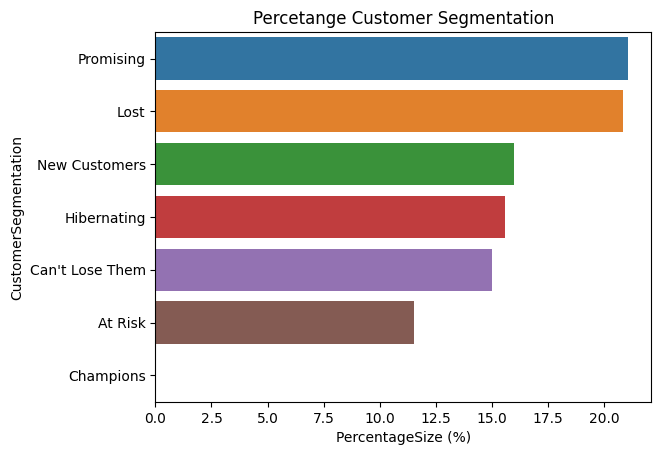

In [87]:
sns.barplot(y = "CustomerSegmentation", x = "PercentageSize", data = customer_segment_df)
plt.xlabel("PercentageSize (%)")
plt.title("Percetange Customer Segmentation")
plt.show()

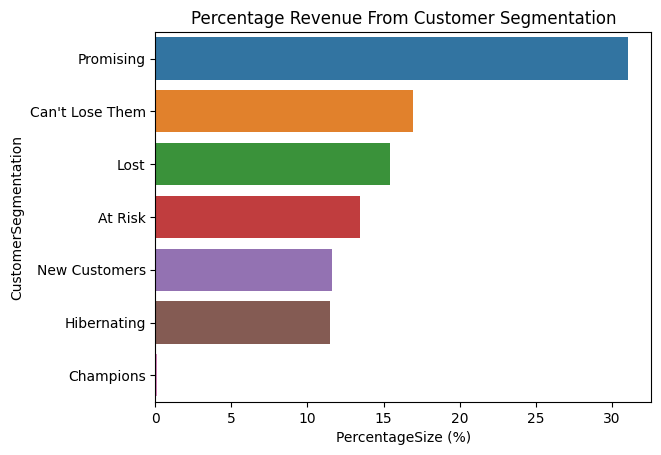

In [88]:
customer_segment_df = customer_segment_df.sort_values(by = "Total$", ascending = False)
sns.barplot(y = "CustomerSegmentation", x = "Percentage$", data = customer_segment_df)
plt.xlabel("PercentageSize (%)")
plt.title("Percentage Revenue From Customer Segmentation")
plt.show()